# Exploratory Data Analysis and Preprocessing - Corn
## Plant Disease Image Classification
MSDS 634 Deep Learning Final Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import textwrap
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from tqdm import tqdm # progress bar

## Decide which dataset version to use
The dataset comes with 3 versions: `color`, `grayscale`, and `segmented`. We'll need to choose one of them to use. Let's see sample images from each:

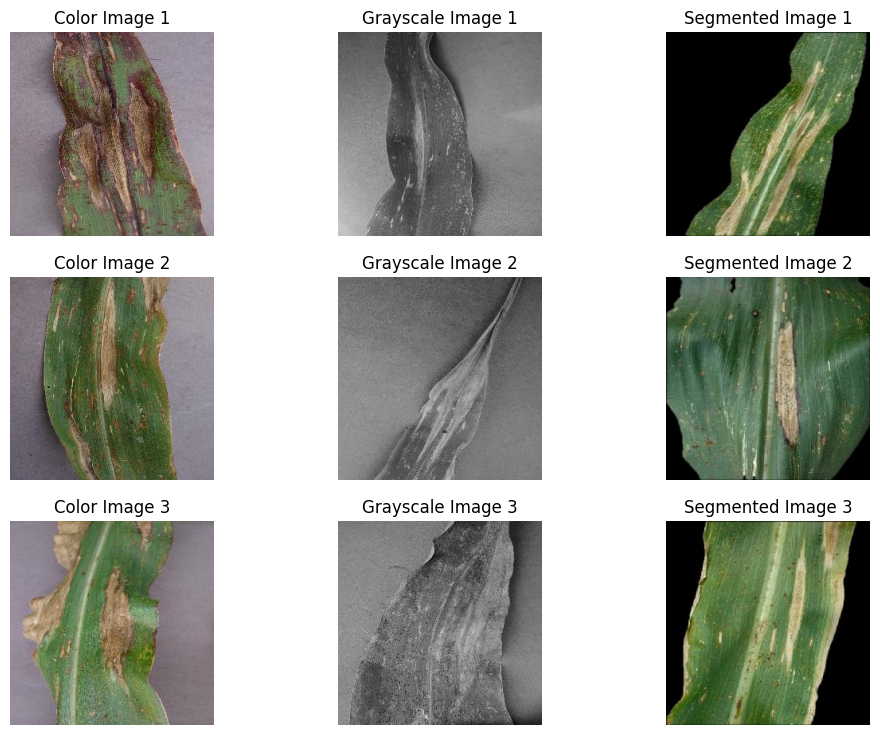

In [3]:
def display_sample_images(color_dir, grayscale_dir, segmented_dir, num_images=3):
    color_files = os.listdir(color_dir)[:num_images]
    grayscale_files = os.listdir(grayscale_dir)[:num_images]
    segmented_files = os.listdir(segmented_dir)[:num_images]

    plt.figure(figsize=(12, 3*num_images))
    for i, (color_file, grayscale_file, segmented_file) in enumerate(zip(color_files, grayscale_files, segmented_files), start=1):

        plt.subplot(num_images, 3, i*3-2)
        color_img = mpimg.imread(os.path.join(color_dir, color_file))
        plt.imshow(color_img)
        plt.title(f'Color Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3-1)
        grayscale_img = mpimg.imread(os.path.join(grayscale_dir, grayscale_file))
        plt.imshow(grayscale_img, cmap='gray')
        plt.title(f'Grayscale Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3)
        segmented_img = mpimg.imread(os.path.join(segmented_dir, segmented_file))
        plt.imshow(segmented_img)
        plt.title(f'Segmented Image {i}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Specify the directories for each dataset
base_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/'
color_dir = base_dir + '/../color_corn/Corn_(maize)___Northern_Leaf_Blight'
grayscale_dir = base_dir + '/grayscale/Corn_(maize)___Northern_Leaf_Blight'
segmented_dir = base_dir + '/segmented/Corn_(maize)___Northern_Leaf_Blight'

# Display sample images from each dataset
display_sample_images(color_dir, grayscale_dir, segmented_dir)


Upon visual inspection of the sample images above, we observe the following about each dataset version:
* `color` - This seems like the raw, original RGB leaf images in color.
* `grayscale` - The leaf images in grayscale. There seems to be some other preprocessing done as there is higher contrast (i.e. the highlights and shadows are more prominent compared to the color version).
* `segmented` - The leaf images with some preprocessing applied including background removal and perhaps increased contrast.

**Using the `color` dataset:** Since the focus of this project is applying deep learning techniques, we would like the neural networks to learn features on their own without extensive preprocessing. Therefore, we will use the `color` version of the dataset.

## Address Outliers
Before we move foward with EDA, let's remove bad data. The Kaggle page gives the following information about the file type distribution:
* `.JPG`: 163k images
* `.png`: 2 images
* `.jpeg`: 2 images

Since there are only 4 images with different file formats out of 163k images, we can safely remove them. Let's find the paths/filenames of the files with `.png` and `.jpeg` extensions:

In [4]:
!find /content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color -name "*.png"

/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color/Pepper,_bell___healthy/42f083e2-272d-4f83-ad9a-573ee90e50ec___Screen Shot 2015-05-06 at 4.01.13 PM.png


In [5]:
!find /content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color -name "*.jpeg"

/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color/Tomato___Late_blight/d0badc95-d04c-457b-8db8-aa6e198f4bd6___GHLB Leaf 10 Day 6.jpeg


The .png and .jpeg images are for bell pepper and tomato. Since we are focusing on corn leaves, we can safely ignore these.



## Load Dataset

**Set up data directory:** Define the directory where the dataset is located.


In [6]:
data_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn'

**Load dataset:** We'll use PyTorch's `datasets.ImageFolder` class to load the dataset. This class automatically infers the classes from the folder structure. The images have a ".JPG" extension which is not accepted by default. Rather than update thousands of filenames, we'll implement a custom class that extends `datasets.ImageFolder` to accept this extension by overriding the `make_dataset()` method.

In [7]:
class CustomImageFolder(datasets.ImageFolder):
    @staticmethod
    def make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
        """
        Overridden method to create a dataset from the directory.
        """
        instances = []
        directory = os.path.expanduser(directory)
        if not ((extensions is None) or isinstance(extensions, str)):
            extensions = tuple(extensions)
        if extensions is not None:
            def is_valid_file(x):
                return datasets.folder.has_file_allowed_extension(x, extensions)
        else:
            def is_valid_file(x):
                return True
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = path, class_index
                        instances.append(item)
        return instances

In [8]:
dataset = CustomImageFolder(root=data_dir)

## Exploratory Data Analysis (EDA)

We'll be working with the classes related to crops for the grape fruit. Let's build an understanding of the images of different grape crops through EDA.

**Calculate dataset statistics:** Let's get some basic statistics about the grape leaves image dataset, such as the number of classes, number of samples per class, and overall dataset size.

In [9]:
num_classes = len(dataset.classes)
class_names = dataset.classes
class_counts = np.bincount(dataset.targets)
dataset_size = len(dataset)
print("Dataset Statistics:")
print("-------------------")
print(f"Number of classes: {num_classes}")
print("Class Names:")
for idx, class_name in enumerate(class_names):
    print(f"  Class {idx}: {class_name}")
print("Class Counts:")
for idx, class_count in enumerate(class_counts):
    print(f"  Class {idx}: {class_count}")
print(f"Total number of samples: {dataset_size}")

Dataset Statistics:
-------------------
Number of classes: 4
Class Names:
  Class 0: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
  Class 1: Corn_(maize)___Common_rust_
  Class 2: Corn_(maize)___Northern_Leaf_Blight
  Class 3: Corn_(maize)___healthy
Class Counts:
  Class 0: 513
  Class 1: 1192
  Class 2: 985
  Class 3: 1162
Total number of samples: 3852


**Plot class distribution:** From the class distribution plot below, we can see that there is class imbalance.

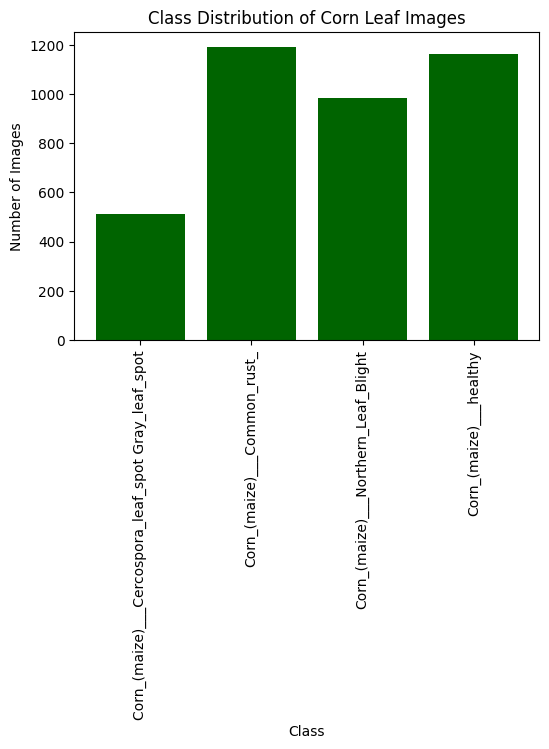

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(class_names, class_counts, color='darkgreen')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Corn Leaf Images')
plt.xticks(rotation=90)
plt.show()

**Visualize sample images:** Let's plot a few sample images from each class to get a sense of what the images look like.

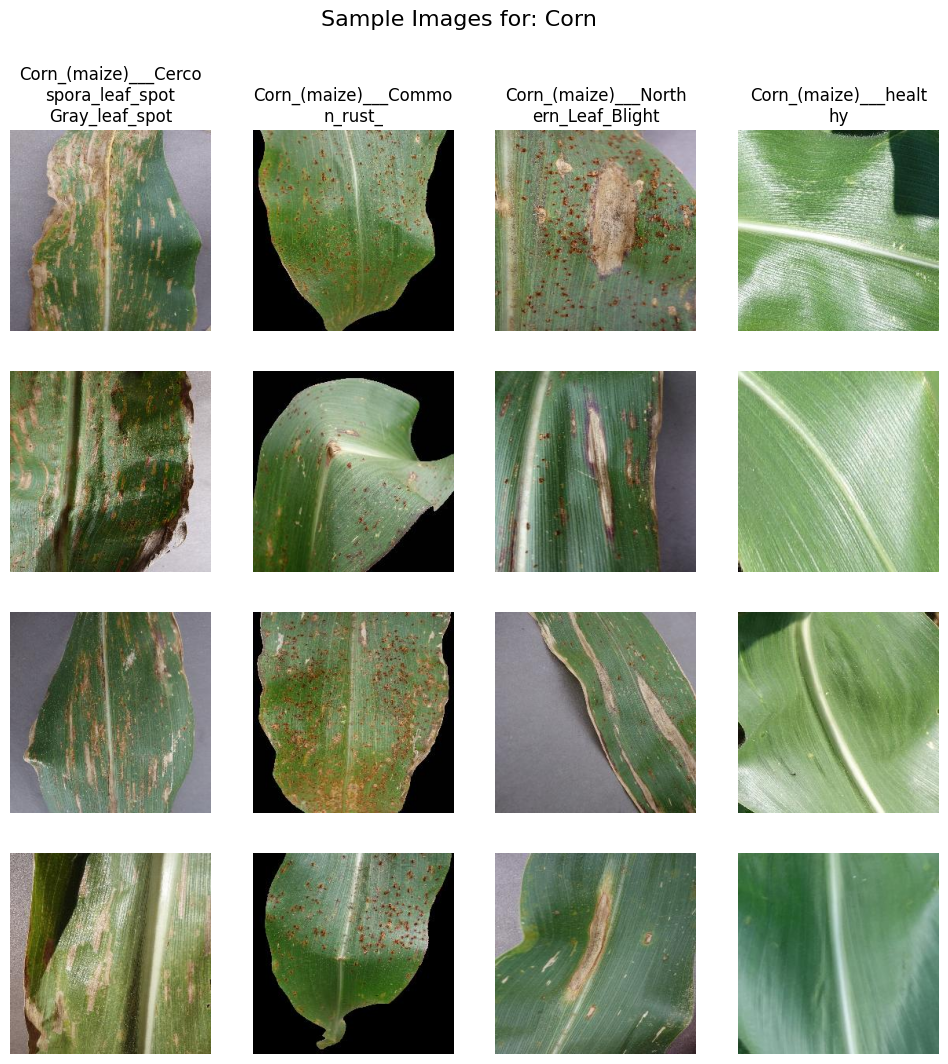

In [11]:
crop_name = 'Corn'

# Get the corn subclass names
subclass_names = []
for subclass_name in dataset.classes:
    if subclass_name.startswith(crop_name):
        subclass_names.append(subclass_name)

num_samples_per_subclass = 4
num_subclasses = len(subclass_names)
num_columns = num_subclasses
num_rows = num_samples_per_subclass

fig, axes = plt.subplots(num_rows, num_columns, figsize=(3*num_columns, 3*num_rows),
                          gridspec_kw={'hspace': 0.2, 'wspace': 0.2})  # Adjust spacing between subplots
fig.suptitle(f"Sample Images for: {crop_name}", fontsize=16)

for i, subclass_name in enumerate(subclass_names):
    subclass_indices = [idx for idx, label in enumerate(dataset.targets) if dataset.classes[label].startswith(crop_name) and subclass_name in dataset.classes[label]]
    if len(subclass_indices) == 0:
        print(f"No samples found for subclass '{subclass_name}'")
        continue
    sample_indices = np.random.choice(subclass_indices, min(num_samples_per_subclass, len(subclass_indices)), replace=False)
    for j, idx in enumerate(sample_indices):
        image, _ = dataset[idx]
        # Convert the PIL image to numpy array
        image_np = np.array(image)
        axes[j, i % num_columns].imshow(image_np)
        axes[j, i % num_columns].axis('off')
        # Add subclass title to the first row of images
        if j == 0:
            # Wrap title if it's longer than 20 characters
            wrapped_title = '\n'.join(textwrap.wrap(subclass_name, width=20))
            axes[j, i % num_columns].set_title(wrapped_title)

plt.show()

We can see that the Common Rust class has a black background, but the Healthy class has no background since the images are up close to the leaves. It will be interesting to see if the neural networks are still able to discern different disease types despite the background color differences.

## Decide Train/Val/Test Split Ratio

Let's consider the following to determine a train/val/test split ratio for our experiments:

* **Class Imbalance:** Since there is a significant variation in the number of images per class, it's essential to ensure that each class is adequately represented in both the training and validation sets to prevent bias towards classes with more data. Therefore, we should employ stratified sampling to maintain the class distribution across the splits.
* **Common Ratios:** Commonly used split ratios include 80% for training, 10% for validation, and 10% for testing. However, given the imbalance in class sizes, it might be beneficial to allocate a higher proportion of data to the validation and testing sets to ensure better representation of each class.

**Final Split Ratio:** With this in mind, we'll use the following split ratio:
* Train set: 70%
* Validation set: 15%
* Test set: 15%

This split ratio ensures sufficient data for training while still providing an adequate number of samples for validation and testing.

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create the ImageFolder dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Get the targets (labels) and class indices
targets = [label for _, label in dataset.samples]
class_indices = {class_name: i for i, class_name in enumerate(dataset.classes)}

# Perform stratified split
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    range(len(dataset)), targets, test_size=0.3, stratify=targets, random_state=634)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices, temp_labels, test_size=0.5, stratify=temp_labels, random_state=634)

# Create datasets using the split indices
train_data = torch.utils.data.Subset(dataset, train_indices)
val_data = torch.utils.data.Subset(dataset, val_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Train dataset size: 2696
Validation dataset size: 578
Test dataset size: 578


## Data Preprocessing
We'll do the following steps to prepare our data for modeling:
1. Normalization according to dataset mean and standard deviation of each color channel. To prevent data leakage, these stats must be calculated from the images in the train set and applied to the train, val and test sets.
1. Resize images to 256x256
1. Save preprocessed image data as numpy files for train, validation, and test

**Calculate mean and standard deviation of RGB channels:** An important preprocessing step for image classification will be normalizing the images. Let's calculate the the mean and standard deviation of each color channel in the train set using sampled images per class. Then we will normalize the images with this information.

In [13]:
# Initialize arrays to store images, widths, heights, and color channel values
images = np.empty((0, 3, 256, 256), dtype=np.float32)
widths = np.empty(0, dtype=np.int32)
heights = np.empty(0, dtype=np.int32)

for batch_images, _ in tqdm(train_loader, desc="Calculating Mean and Std from Train, processing batches", leave=False):
    # Convert batch images to numpy arrays
    batch_images_np = batch_images.numpy()
    # Append batch images to the array of images
    images = np.concatenate((images, batch_images_np), axis=0)
    # Get batch widths and heights
    batch_widths = batch_images_np.shape[2]
    batch_heights = batch_images_np.shape[3]
    # Append batch widths and heights to the respective arrays
    widths = np.concatenate((widths, np.full(batch_images_np.shape[0], batch_widths, dtype=np.int32)))
    heights = np.concatenate((heights, np.full(batch_images_np.shape[0], batch_heights, dtype=np.int32)))

# Calculate mean and standard deviation for each channel
mean_width = np.mean(widths)
mean_height = np.mean(heights)
mean_per_channel = np.mean(images, axis=(0, 2, 3))
std_per_channel = np.std(images, axis=(0, 2, 3))

# Print mean and standard deviation for each channel
print("Statistics for Train Set:")
print("=================================")
print("Mean Width:", mean_width)
print("Mean Height:", mean_height)
print("Mean per channel:", mean_per_channel)
print("Standard deviation per channel:", std_per_channel)


Statistics for Train Set:
Mean Width: 256.0
Mean Height: 256.0
Mean per channel: [0.43613595 0.4974372  0.3781651 ]
Standard deviation per channel: [0.21189487 0.22010513 0.21154968]


**Define and apply transformations:** Define the transformations we'll apply to the images. These transformations will include resizing and normalization according to the mean width/height, and mean/standard deviations of each color channel we just calculated.

In [13]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.43613595, 0.4974372, 0.3781651],
                         std=[0.21189487, 0.22010513, 0.21154968]),  # Normalize using mean and std
])

# Apply transformations to datasets
train_data.transform = transform
val_data.transform = transform
test_data.transform = transform

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

**Save preprocessed data as numpy files:** We'll be saving our preprocessed data as numpy files to be loaded for model training later. There are several benefits to saving the loading numpy files instead of loading .JPG files with datasets.ImageFolder:
* We can take advantagge of vectorization with numpy data.
* Loading data from a single numpy file involves fewer I/O operations compared to loading multiple image files from disk, which can lead to faster data loading times.
* This efficiencies will make a significant difference in model processing time.

In [14]:
# Function to save data and labels as numpy files
def save_as_numpy(loader, save_dir, name):
    num_samples = len(loader.dataset)
    data_array = np.empty((num_samples, 3, 256, 256), dtype=np.float32)
    label_array = np.empty((num_samples,), dtype=np.int32)

    index = 0
    # Use tqdm to create a progress bar for the iteration
    with tqdm(total=num_samples, desc=f"Saving {name} data") as pbar:
        for batch_idx, (data, labels) in enumerate(loader):
            batch_size = len(data)
            data_array[index:index+batch_size] = data.numpy()
            label_array[index:index+batch_size] = labels.numpy()
            index += batch_size
            pbar.update(batch_size)  # Update the progress bar
            pbar.set_postfix(batch=batch_idx)  # Update the batch number

    np.save(os.path.join(save_dir, f"{name}_data.npy"), data_array)
    np.save(os.path.join(save_dir, f"{name}_labels.npy"), label_array)

# Define the directory to save the numpy files
save_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn'

# Save train, validation, and test sets
save_as_numpy(train_loader, save_dir, 'train')
save_as_numpy(val_loader, save_dir, 'val')
save_as_numpy(test_loader, save_dir, 'test')

Saving test data: 100%|██████████| 578/578 [02:28<00:00,  3.89it/s, batch=9]


## Summary of EDA Takeaways
Here are the main takeaways from EDA and how it will inform our model experiments:

1. **Class Imbalance** - Our dataset has significant data imbalance across 4 corn subclasses. To address this, instead of undersampling (losing data) or oversampling (will increase processing time and requires more compute power), we'll need to use the class weights when training the model.
2. **Using F1 Score as our primary metric** - Since we have an imbalanced dataset, we shouldn't use accuracy. We'll use F1 score as our primary evaluation metric for selecting our best models since it balances between precision and recall, accounting for imbalanced datasets.